# Assignment 4

`The empires of the future are the empires of the mind.
-Winston Churchill`

---

## Libraries


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from pandas.plotting import register_matplotlib_converters
from IPython.display import display
from tsa_functions import *

register_matplotlib_converters()
sns.set_style('darkgrid')

np.set_printoptions(precision=4)
pd.set_option('precision', 4)

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [2]:
from tsa_tools import *  # See last cell

---

## M5 Competition

For this assignment, we'll be continuing our exploration of M5 dataset. 

Specifically, we will be forecasting at level 3 (unit sales of all products, aggregated for each store).

Load the following files:

- `calendar.csv`


- `sales_train_validation.csv`


- `sales_train_evaluation.csv`



In [3]:
df_calendar = pd.read_csv('data/m5/calendar.csv')
df_price = pd.read_csv('data/m5/sell_prices.csv')
df_sales = pd.read_csv('data/m5/sales_train_validation.csv')

In [4]:
display(df_calendar, df_price, df_sales)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


---

### Q1.

Extract the `CA_1` series and <u>replace all values below 10</u> with linear interpolations (similar to the discussion notebook).

Perform recursive STL decompositions and extract the following series: `seasonal_7`, `seasonal_30`, `seasonal_365`, `trend`, and `residual`.

Use the following forecast methods:

- `Seasonal Naive` for the `seasonal_7`, `seasonal_30`, and `seasonal_365` series.


- `Holt's Linear Method` for the `trend` series.


- An un-tuned `LightGBM` with 28-day lookback that uses a one-step recursive forecasting strategy for the `residual` series.

Generate a 28-day forecast and calculate the `MAE`, `RMSE`, `MASE`, and `RMSSE` against the validation observations `d_1914 to d_1941` in `sales_train_evaluation.csv`. Print the metrics as a dataframe.

In [5]:
full_df = (df_sales.set_index([*df_sales.columns[5::-1]]).T
           .set_index(pd.DatetimeIndex(df_calendar.date)[:1913]))

In [6]:
test_df = pd.read_csv('data/m5/sales_train_evaluation.csv')
test_df = (test_df.set_index([*test_df.columns[5::-1]]).T
           .set_index(pd.DatetimeIndex(df_calendar.date)[:1941])).iloc[-28:]
test = test_df.xs('CA_1', level=1, axis=1).sum(axis=1)

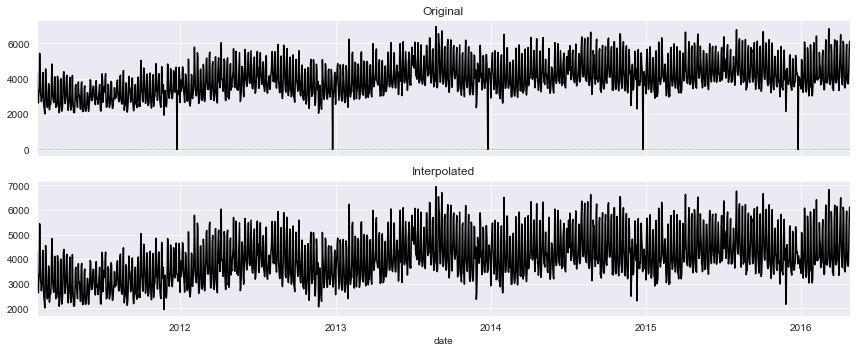

In [7]:
series = timeSeriesFiltering(
    full_df.xs('CA_1', level=1, axis=1).sum(axis=1), lower=10, plot=True);

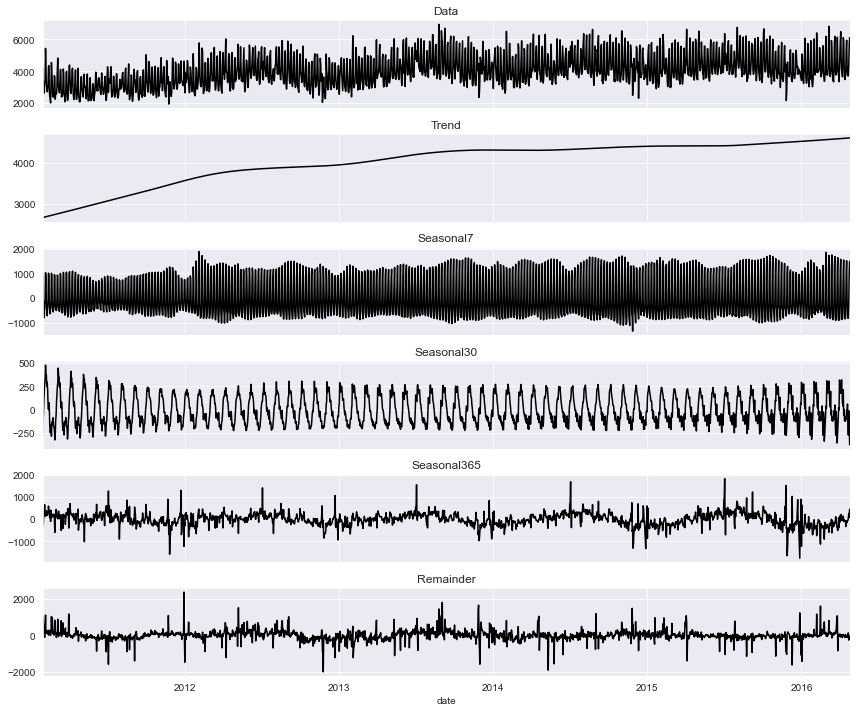

In [8]:
mslt(series, s=[7, 30, 365], plot=True);

In [9]:
model = ensemble1(w=28, s=[7, 30, 365])
fit = model.fit(series, lower=10)
res = fit.forecast(28)
res

,Data,Trend,Seasonal7,Seasonal30,Seasonal365,Remainder
2016-04-25,4252.27,4608.53,-17.17,-303.52,21.92,-57.49
2016-04-26,3610.51,4609.31,-715.43,-204.00,-38.01,-41.35
2016-04-27,3439.92,4610.08,-815.62,-101.84,-55.94,-196.76
2016-04-28,3560.28,4610.86,-815.33,21.95,-159.65,-97.56
2016-04-29,4481.62,4611.64,-213.51,-3.00,34.32,52.18
2016-04-30,6446.60,4612.42,1007.75,317.68,598.80,-90.06
2016-05-01,6502.51,4613.20,1487.27,281.20,165.68,-44.83
2016-05-02,5175.57,4613.98,-17.17,175.94,490.02,-87.21
2016-05-03,4518.17,4614.76,-715.43,200.29,414.08,4.47
2016-05-04,4408.16,4615.53,-815.62,218.85,329.89,59.50


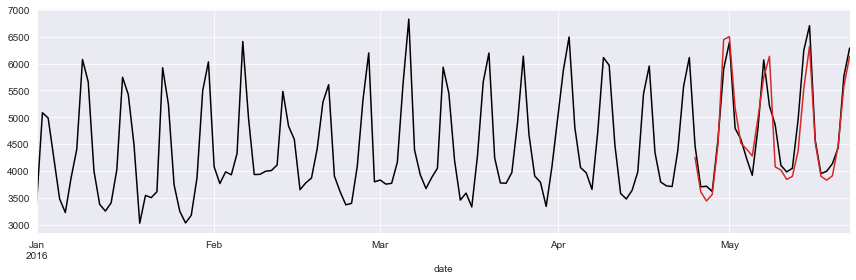

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
series.loc['2016-01-01':].append(test).plot(ax=ax, c='k', label='Data')
res.Data.plot(ax=ax, label='Forecast', c='tab:Red')
fig.tight_layout()

In [11]:
rateMyForecast(
    series.rename('CA_1').to_frame(),
    test.rename('CA_1').to_frame(),
    res.Data.rename('CA_1').to_frame()
);

,MAE,RMSE,MASE,RMSSE
Group,,,,
CA_1,268.42,356.19,0.42,0.43


### Q2.

Repeat the process done in Q1 for all other series in level 3. Print a dataframe that summarizes the error metrics per series.

In [12]:
forcats = {}
for label, content in tqdm.tqdm(full_df.sum(axis=1, level=1).items()):
    model = ensemble1(w=28, s=[7, 30, 365])
    fit = model.fit(content, lower=10)
    res = fit.forecast(28)
    forcats[label] = res.Data
forcats_df = pd.DataFrame(forcats)

10it [01:12,  7.22s/it]


In [13]:
res = rateMyForecast(
    timeSeriesFiltering(full_df.sum(axis=1, level=1), lower=10),
    test_df.sum(axis=1, level=1),
    forcats_df
)

,MAE,RMSE,MASE,RMSSE
Group,,,,
CA_1,268.42,356.19,0.42,0.43
CA_2,430.70,556.20,0.84,0.76
CA_3,462.92,597.45,0.68,0.67
CA_4,194.39,240.61,0.87,0.85
TX_1,416.27,510.34,0.97,0.92
TX_2,422.38,521.83,0.78,0.72
TX_3,451.27,576.31,1.11,1.11
WI_1,289.60,396.83,0.59,0.58
WI_2,722.23,1011.95,1.42,1.48


<div class="alert alert-block alert-warning">
    <b>NOTE:</b> For scaled errors, we were advised to use the interpolated (for values below 10) series.
</div>

### Q3.

Calculate the `WRMSSE` at level 3. The weights can be found in `weights_validation.csv`.

For reference, the best performing benchmark `ES_bu` has a `WRMSSE`score of <b>0.580</b> at level 3. 

In [14]:
df_weights = pd.read_csv('weights_validation.csv')
df_weights = df_weights.loc[df_weights['Level_id'] == 'Level3']

In [15]:
print(f'WRMSSE score = {(res.RMSSE * df_weights.Weight.values).sum():.6f}')

WRMSSE score = 0.832710


### Q4.

Based on your answers in Q2 and Q3, where can we improve? What should we try next?

<div class="alert alert-block alert-success">
    We can try to do the following:
    <ul>
        <li>Iterate between different models/strategies using <code>TCSV</code>
            <ul>
                <li>Try forecasting sales without decomposing (e.g., using <code>LGB</code> which sort of does multiple decomposition).</li>
                <li>For this particular case, we only used <code>recursive-forecasting</code>. Other methods can also be employed for forecasting the next 𝑛-days, such as  <code>direct-forecasting</code> and <code>single-shot-forecasting</code>, and hybrid ones.</li>
                <li>Try out <code>bottom-up</code> and <code>top-down</code> approaches</li>
            </ul>
        </li>
        <li>Refine the models by tuning hyperparameters using <code>TCSV</code>
            <ul>
                <li>Decomposition works for some, such as with <code>CA_1</code> and <code>CA_2</code>; we can try further tuning them.</li>
                <li>For ML Models such as <code>LGB</code>:
                    <ul>
                        <li>Tune the lookback window, and</li>
                        <li>Tune <code>LGB</code>'s hyperparameters.</li>
                    </ul>
                </li>
            </ul>
        </li>
        <li>We can try to introduce exogenous variables, such as the calendar events, and other engineered features (e.g., DoW, WoM, DoY, etc.)</li>
    </ul>
</div>

<div class="alert alert-block alert-info>fff</div>

In [16]:
%%writefile tsa_tools.py
# Authors
# * Adriane Mikko A. Amorado
# * Nika Karen O. Espiritu
# * Joanna Beb G. Quinto

#############
## Imports ##
#############
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import STL
from IPython.display import clear_output
from matplotlib import pyplot as plt
from IPython.display import display
from itertools import product
from datetime import datetime
from tsa_functions import *
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import tqdm
import json


warnings.filterwarnings("ignore")
register_matplotlib_converters()
sns.set_style('darkgrid')
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)


###############
## Functions ##
###############

def timeSeriesFiltering(ts, lower=np.NINF, upper=np.inf, plot=False):
    if plot:
        fig, axes = plt.subplots(figsize=(12, 5), nrows=2, sharex=True)
        ts.plot(ax=axes[0], title='Original', c='k')
        axes[0].axhline(lower, c='r', lw=0.5, ls=':')
        axes[0].axhline(upper, c='r', lw=0.5, ls=':')

    ts = (ts
          .where((ts >= lower) & (ts <= upper))
          .interpolate(method='time'))

    if plot:
        ts.plot(ax=axes[1], title='Interpolated', c='k')
        plt.tight_layout()

    return ts


def mslt(ts, s=[12], plot=False):
    components = {'Data': ts}
    series = ts.copy()
    for t in s:
        res = STL(
            series, period=t, seasonal=t if t % 2 else t+1, robust=True).fit()
        components[f'Trend'] = res.trend
        components[f'Seasonal{t}'] = res.seasonal
        series = res.trend + res.resid
    components[f'Remainder'] = res.resid
    res = pd.DataFrame(components)
    if plot:
        res.plot(
            subplots=True, layout=(-1, 1), figsize=(12, 10), color='k',
            title=[*res.columns], legend=False)
        plt.tight_layout()
    return res


#####################################
##             Metrics             ##
#####################################

def mae(y_true, y_pred):
    score = np.mean(np.abs(y_true - y_pred))
    return score


def rmse(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError('Lengths Mismatch')
    score = np.sqrt(np.mean((y_true - y_pred)**2))
    return score


def mase(y_true, y_pred, s_ts):
    if len(y_true) != len(y_pred):
        raise ValueError('Lengths Mismatch')
    ts = s_ts.to_numpy()
    score = np.mean(
        np.abs((y_true - y_pred)/np.mean(np.abs(ts[1:] - ts[:-1]))))
    return score


def rmsse(y_true, y_pred, ts):
    if len(y_true) != len(y_pred):
        raise ValueError('Lengths Mismatch')
    ts = ts.to_numpy()
    score = np.sqrt(
        np.mean((y_true - y_pred)**2)/np.mean((ts[1:] - ts[:-1])**2))
    return score


def rateMyForecast(train, test, forecast):
    """
    Evalute the forcast per group, given train, test, and forecast tables.

    The function evaluates the metrics per column of the provided table.

    Parameters
    ----------
    train : DataFrame
        DataFrame contaning the train set.
    test : DataFrame
        DataFrame contaning the train set.
    forecast : DataFrame
        DataFrame contaning the train set.

    Returns
    -------
    DataFrame
        DataFrame contaning the metrics as columns, groups as rows,
        and scores as values.

    """
    res = pd.DataFrame([
        {'Group': col,
         'MAE': mae(test[col], forecast[col]),
         'RMSE': rmse(test[col], forecast[col]),
         'MASE': mase(test[col], forecast[col], train[col]),
         'RMSSE': rmsse(test[col], forecast[col], train[col])}
        for col in test])
    display(res.set_index('Group'))
    return res.set_index('Group')


#############################################
##             Model Selection             ##
#############################################

def TimeseriesGenerator(X, y, w, h):
    X_train = np.vstack(timeseries_dataset_from_array(
        X, targets=None, sequence_length=w, end_index=len(X)-h))
    y_train = np.vstack(timeseries_dataset_from_array(
        X, targets=None, sequence_length=h, start_index=w))
    X_test = X[None, -w:]
    y_test = y[None, :] if y else None
    return X_train, X_test, y_train, y_test


def cross_val_score(X, est, config, scoring, cv):
    param = config.copy()
    h = param.pop('h')
    w = param.pop('w')
    folds = cv.split(X, h)
    scores = {metric: [] for metric in scoring}
    for train, val in folds:
        X_train, X_test, y_train, y_test = TimeseriesGenerator(
            train, val, w, h)
        est.set_params(**param)
        est.fit(X_train, y_train)
        y_hat = est.predict(X_test)
        for metric in scores:
            scores[metric].append(scoring[metric](y_test, y_hat))
    return scores


def cross_val_predict(X, est, config, cv):
    param = config.copy()
    h = param.pop('h')
    w = param.pop('w', None)
    folds = cv.split(X, h)
    fit_params = {}
    res = {}
    for k, (train, val) in enumerate(folds):
        if w:
            X_train, X_test, y_train, y_test = TimeseriesGenerator(
                train, val, w, h)
            est.set_params(**param)
            est.fit(X_train, y_train)
            y_hat = est.predict(X_test)[0]
        else:
            try:
                model = est(X, **param)
                fit = model.fit(**fit_params)
                y_hat = fit.forecast(h)
            except:
                y_hat = np.full(len(val), np.nan)
        res.update({(k, i): y for i, y in enumerate(y_hat)})
    return res


class TimeSeriesSplit:
    def __init__(self, val_size):
        self.val_size = val_size

    def split(self, design_set, h):
        val_end = len(design_set)
        divider = val_end - h
        dataset = []
        while len(design_set) - divider <= self.val_size:
            dataset.append(
                (design_set[np.arange(0, divider)],
                 design_set[np.arange(divider, val_end)]))
            val_end -= 1
            divider -= 1
        return dataset[::-1]


class GridSearchCV:
    def __init__(self, estimator, param_grid, cv, scoring=[]):
        self.est = estimator
        self.param_grid = param_grid
        self.param_list = [
            dict(zip(param_grid.keys(), params))
            for params in product(*param_grid.values())]
        self.cv = cv
        self.scoring = scoring

    def fit(self, X, scores=False):
        self.cv_results_ = []
        self.df_records_ = []
        for param in tqdm.tqdm(self.param_list):
            if scores:
                res = {
                    'params': param.copy(),
                    **cross_val_score(
                        X, self.est, param, self.scoring, self.cv)}
                rec = {
                    'Lookback': res['params']['w'],
                    'Horizon': res['params']['h'],
                    'Average RMSE': np.mean(res['rmse']),
                    'Stdev RMSE': np.std(res['rmse'])}
                rec['Sum'] = (rec['Average RMSE'] + rec['Stdev RMSE'])
#                 self.best_params = (
#                     self.df.nsmallest(1, 'Sum').iloc[0].to_dict())
            else:
                res = {
                    'params': param.copy(),
                    **cross_val_predict(
                        X, self.est, param, self.cv)}
                rec = res
            self.cv_results_.append(res)
            self.df_records_.append(rec)
        self.df = pd.DataFrame(self.df_records_)


def forecastUsingConfig(est, regions, design_set, test_set):
    forecast = {}
    for region in regions:
        train = design_set[region['Region']]
        test = test_set[region['Region']]
        w = int(region['Lookback'])
        h = int(region['Horizon'])
        X_train, X_test, y_train, y_test = TimeseriesGenerator(
            train, test, w, h)
#         est.set_params(**param)
        fit = est.fit(X_train, y_train)
        forecast[region['Region']] = fit.predict(X_test)[0]
    forecast_set = pd.DataFrame(forecast)
    forecast_set.index = test_set.index
    return forecast_set


###############
## Ensembles ##
###############

class ensemble1:
    def __init__(self, w, s):
        self.w = w
        self.s = s=[7, 30, 365]
    
    def fit(self, ts, lower=np.NINF, upper=np.inf, ):
        series = timeSeriesFiltering(ts, lower, upper)
        self.res = mslt(series, s=self.s)
        
        # Seasonal
        
        # Trend
        self.trend_fit = ETSModel(self.res.Trend, trend='add').fit()
        
        # Residuals
        X_train, _, y_train, _ = TimeseriesGenerator(
            self.res.Remainder, y=None, w=self.w, h=1)
        resid_model = lgb.LGBMRegressor(random_state=1)
        self.resid_fit = resid_model.fit(X_train, y_train)
        
        return self
    
    def forecast(self, h):
        forecasts = {'Data': np.nan}
        forecasts['Trend'] = self.trend_fit.forecast(h)
        for seasonality in self.s:
            forecasts[f'Seasonal{seasonality}'] = snaivef(
                self.res[f'Seasonal{seasonality}'], h, seasonality)
        resid = self.res.Remainder.tolist()
        for _ in range(h):
            f = self.resid_fit.predict([resid[-self.w:]])
            forecasts.setdefault('Remainder', []).extend(f)
            resid.extend(f)
        return pd.DataFrame(forecasts).assign(
            Data=lambda x: np.nansum(x, axis=1))

Overwriting tsa_tools.py
